# 코랩 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 라이브러리 install & import

In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.7 MB/s eta 0:00:00


In [3]:
!pip install -q sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 9.8 MB/s eta 0:00:00


In [4]:
!pip install bayesian-optimization

In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.4 MB/s eta 0:00:00


In [6]:
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
from datetime import datetime
import math
import os
import xgboost as xgb
import platform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [7]:
import warnings

# 모든 경고를 무시하도록 설정
warnings.filterwarnings("ignore")

# 데이터셋

In [8]:
# 모든 컬럼을 보여주도록 설정
pd.set_option('display.max_columns', None)

df = pd.read_csv('/content/drive/MyDrive/bee_data_0601ver.csv')

df

,연도,분기,지역,hum,tem,rain,SO2,NO2,O3,CO,PM10,PM2.5,sacbrood,wind,sun
0,2018,1,경기,62.105397,-0.166667,32.766667,0.004946,0.029183,0.021151,0.580645,56.774194,35.946237,1,1.786667,62.244000
1,2018,2,경기,70.884377,17.166667,156.966667,0.003538,0.019839,0.036817,0.396774,46.247312,24.365591,1,1.813333,52.405333
2,2018,3,경기,77.074957,24.700000,183.000000,0.003065,0.014065,0.027247,0.348387,24.236559,12.397849,1,1.466667,54.034667
3,2018,4,경기,68.506293,5.233333,66.133333,0.003570,0.028914,0.014527,0.556989,48.247312,27.591398,1,1.260000,60.632000
4,2019,1,경기,60.782458,1.166667,21.600000,0.004333,0.030344,0.021065,0.646237,68.709677,42.204301,1,1.493333,62.636667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022,4,제주,72.008643,13.533333,52.133333,0.001167,0.007333,0.040167,0.266667,28.166667,14.333333,0,4.075000,49.432500
236,2023,1,제주,70.400253,9.033333,63.500000,0.001600,0.008300,0.043900,0.333333,40.666667,18.000000,0,3.750000,46.427500
237,2023,2,제주,77.609485,18.700000,278.400000,0.001533,0.006500,0.047733,0.250000,39.666667,14.333333,0,3.466667,42.005000
238,2023,3,제주,86.916058,26.666667,204.866667,0.001500,0.005300,0.032800,0.266667,20.000000,10.333333,0,3.141667,44.953333


## 데이터 전처리

In [9]:
# 연도, 분기 열 drop
df = df.drop(['연도','분기','지역'], axis=1)
df

,hum,tem,rain,SO2,NO2,O3,CO,PM10,PM2.5,sacbrood,wind,sun
0,62.105397,-0.166667,32.766667,0.004946,0.029183,0.021151,0.580645,56.774194,35.946237,1,1.786667,62.244000
1,70.884377,17.166667,156.966667,0.003538,0.019839,0.036817,0.396774,46.247312,24.365591,1,1.813333,52.405333
2,77.074957,24.700000,183.000000,0.003065,0.014065,0.027247,0.348387,24.236559,12.397849,1,1.466667,54.034667
3,68.506293,5.233333,66.133333,0.003570,0.028914,0.014527,0.556989,48.247312,27.591398,1,1.260000,60.632000
4,60.782458,1.166667,21.600000,0.004333,0.030344,0.021065,0.646237,68.709677,42.204301,1,1.493333,62.636667
...,...,...,...,...,...,...,...,...,...,...,...,...
235,72.008643,13.533333,52.133333,0.001167,0.007333,0.040167,0.266667,28.166667,14.333333,0,4.075000,49.432500
236,70.400253,9.033333,63.500000,0.001600,0.008300,0.043900,0.333333,40.666667,18.000000,0,3.750000,46.427500
237,77.609485,18.700000,278.400000,0.001533,0.006500,0.047733,0.250000,39.666667,14.333333,0,3.466667,42.005000
238,86.916058,26.666667,204.866667,0.001500,0.005300,0.032800,0.266667,20.000000,10.333333,0,3.141667,44.953333


In [10]:
# 11개 열은 input feature, sacbrood 열은 예측 대상
# 특정 인덱스에 있는 열 선택
selected_columns = list(range(9)) + [10, 11]
X_df = df.iloc[:, selected_columns]
y_df = df['sacbrood']

In [11]:
# 결측치 확인
df.isnull().sum()

hum         0
tem         0
rain        0
SO2         0
NO2         0
O3          0
CO          0
PM10        0
PM2.5       0
sacbrood    0
wind        0
sun         0
dtype: int64

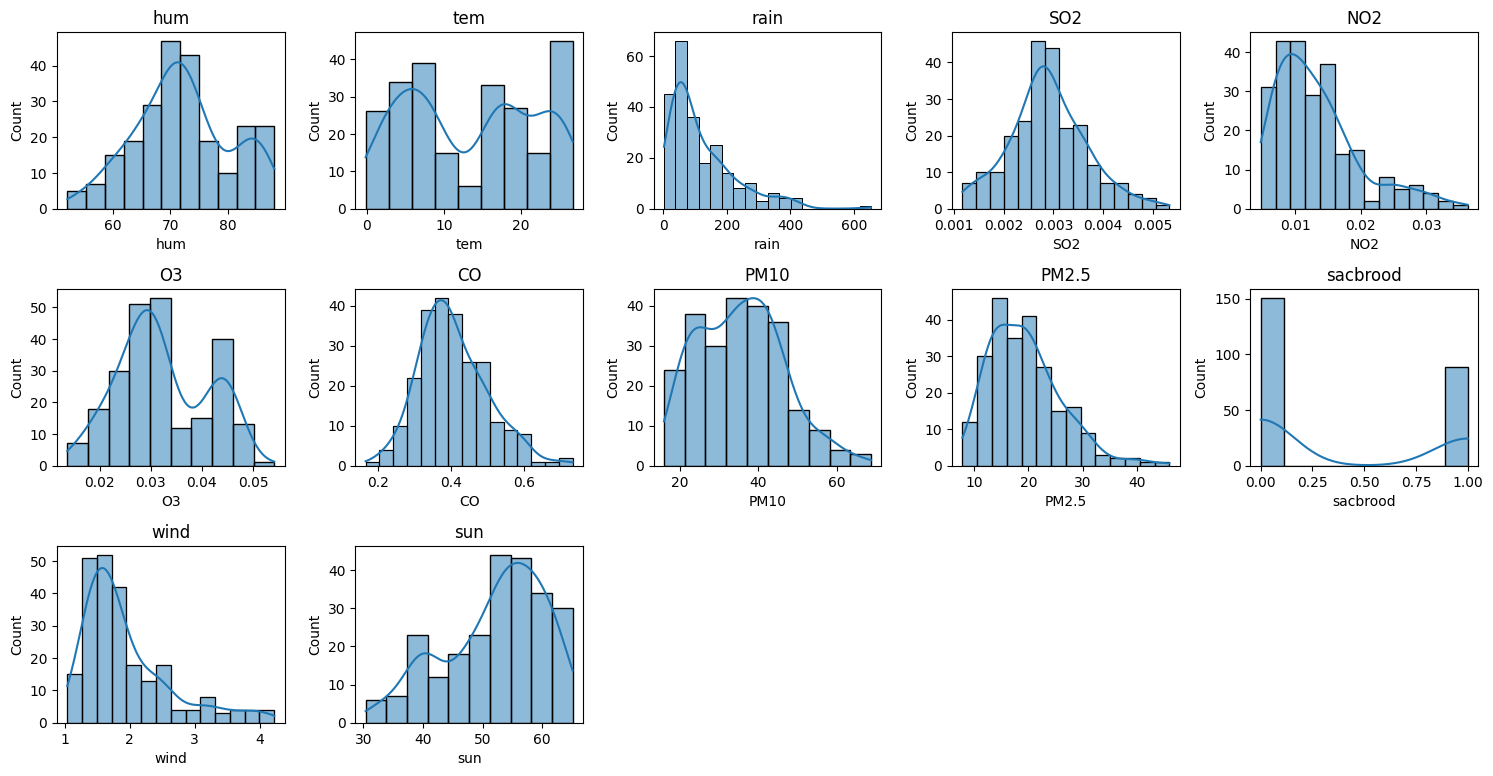

In [12]:
# 각 Feature의 분포 확인
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.iloc[:,:18].columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[col], kde=True)  # 히스토그램과 KDE(커널 밀도 추정) 그리기
    plt.title(col)

plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()

## Feature 간 상관관계 및 다중공선성 확인

<Axes: >

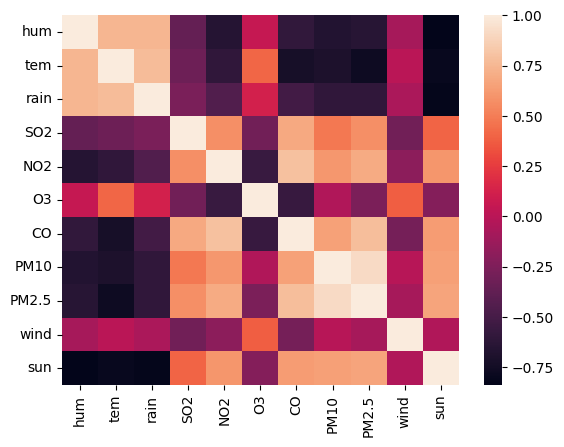

In [13]:
# Heatmap을 통해 변수들 간 상관관계 파악
sns.heatmap(X_df.corr())

In [14]:
# 변수들 간 다중공선성 확인
# 상수항 추가
df_with_constant = add_constant(X_df)

# VIF 계산 함수
def calculate_vif(df):
    vif = pd.DataFrame()
    vif['Feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# VIF 계산
vif_data = calculate_vif(df_with_constant)
# 상수항 제거
vif_data = vif_data[vif_data['Feature'] != 'const']

# VIF 내림차순 정렬
vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)

print(vif_data_sorted)

   Feature        VIF
9    PM2.5  12.111021
8     PM10  10.765554
2      tem   9.245432
1      hum   7.859888
7       CO   6.693916
5      NO2   6.677904
6       O3   5.999342
11     sun   5.686889
3     rain   3.881688
4      SO2   2.570964
10    wind   1.394803


const(상수항)은 제거하고 보는 게 맞음. VIF가 10이상이면 다중공선성이 있다고 판단되므로 다중공선성 처리해야 함.  
일반적으로 다중공선성 제거는 1. 다중공선성 높은 순으로 변수 제거, 2. 차원 축소 이렇게 두 가지 방법으로 함.  
변수 제거보다는 비슷한 변수끼리 합치는 방식의 차원 축소가 더 나을 것으로 판단하여 PCA를 진행.  

## Scaling

In [15]:
# 스케일링
scaler = StandardScaler()
X_df_scaled = X_df.copy()

X_df_scaled[X_df.columns] = scaler.fit_transform(X_df[X_df.columns])
# 결과 확인
X_df_scaled.head()

,hum,tem,rain,SO2,NO2,O3,CO,PM10,PM2.5,wind,sun
0,-1.215626,-1.639773,-0.842078,2.669534,2.467315,-1.271820,1.862984,1.973603,2.495161,-0.232797,1.226665
1,-0.150334,0.451907,0.367536,0.844684,1.017667,0.529403,-0.093609,0.999094,0.756789,-0.193443,0.041280
2,0.600866,1.360983,0.621081,0.231757,0.121854,-0.570864,-0.608502,-1.038515,-1.039690,-0.705047,0.237586
3,-0.438904,-0.988135,-0.517112,0.886474,2.425610,-2.033353,1.611258,1.184241,1.241015,-1.010041,1.032448
4,-1.376159,-1.478875,-0.950833,1.875515,2.647478,-1.281710,2.560950,3.078510,3.434560,-0.665693,1.273974


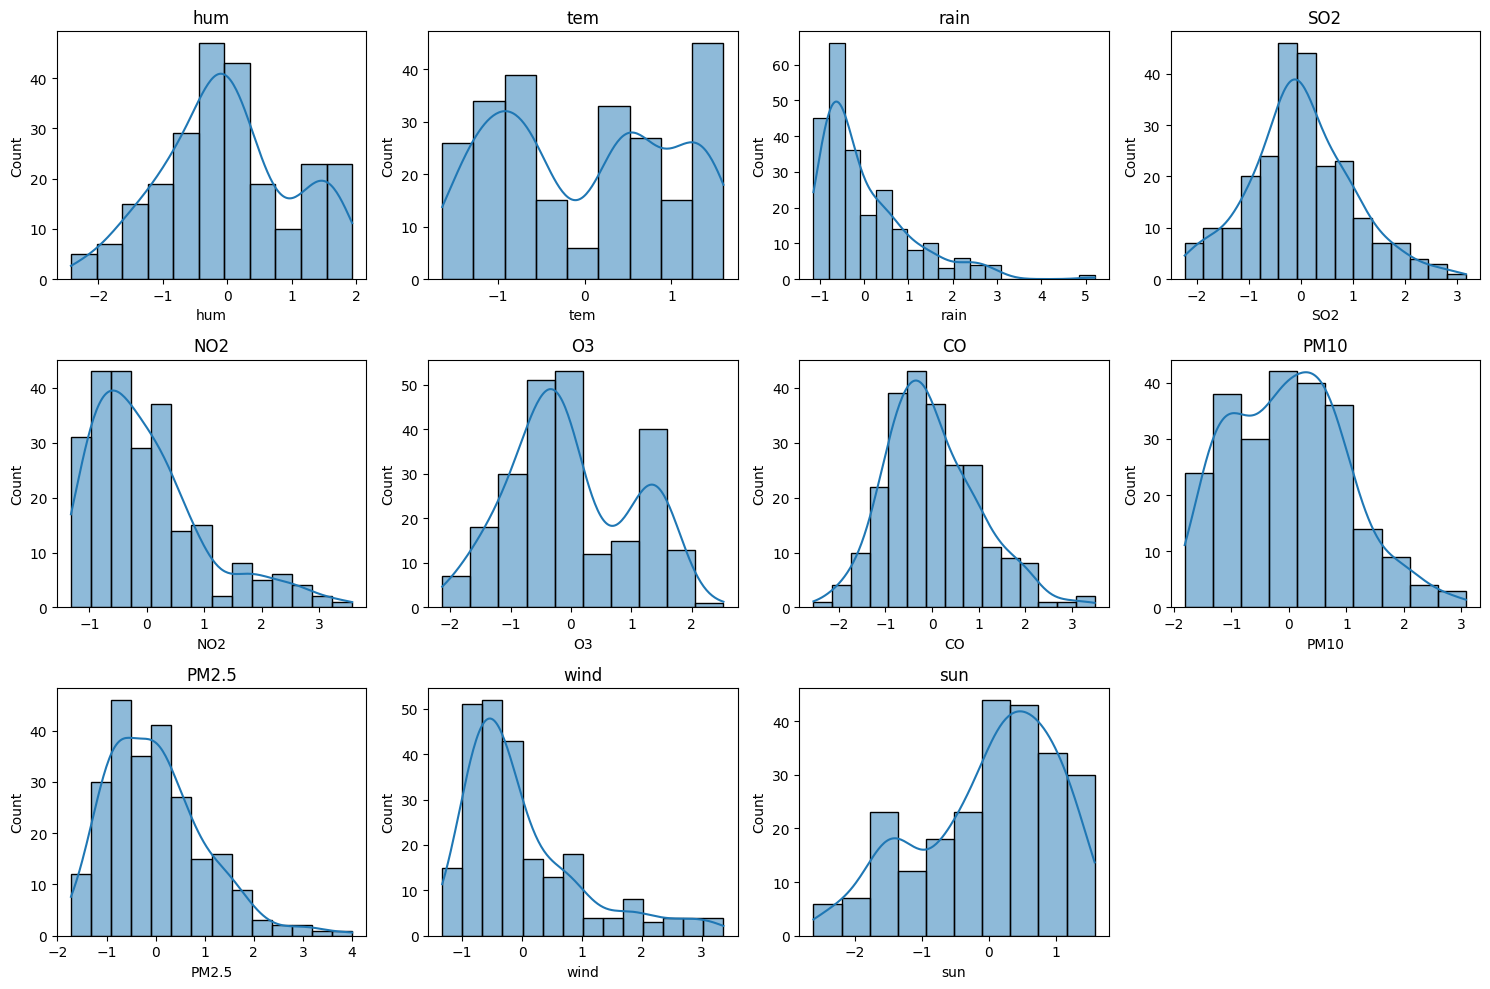

In [16]:
# Scaling 이후 각 Feature의 분포 다시 확인
plt.figure(figsize=(15, 10))
for i, col in enumerate(X_df_scaled.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(X_df_scaled[col], kde=True)  # 히스토그램과 KDE(커널 밀도 추정) 그리기
    plt.title(col)

plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()

각 Feature들이 스케일링이 잘 된 것을 확인할 수 있음.  

## PCA

In [17]:
pca = PCA(n_components=11) # 원래 Feature 11개이므로, 11을 입력하여
pca_array = pca.fit_transform(X_df_scaled)
pca_df = pd.DataFrame(pca_array, index = X_df_scaled.index, columns = [f"pca{num+1}" for num in range(X_df_scaled.shape[1])])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11
0,5.536462,-1.185555,1.132653,1.014663,-0.147287,0.146866,-0.291185,0.287869,-0.452569,-0.010702,0.267530
1,0.826632,-0.198485,1.518076,0.242614,-0.046053,-0.713920,-0.528306,0.315188,-0.104451,-0.081973,0.126872
2,-1.481671,-1.281856,-0.296728,-0.411170,-1.037504,-0.262209,-0.547094,0.641046,0.319979,0.060806,-0.140239
3,3.804231,-1.979534,-0.463943,0.554735,0.266285,-0.628641,-0.582581,0.198961,0.202396,-0.252565,0.041145
4,6.416205,-1.129821,1.439502,0.909387,1.071313,-0.497050,-0.387818,0.059715,0.201274,0.339344,-0.069002


In [18]:
result = pd.DataFrame({'설명가능한 분산 비율(고유값)':pca.explained_variance_, '기여율': pca.explained_variance_ratio_},
                      index = np.array([f"pca{num+1}" for num in range(X_df_scaled.shape[1])]))
result['누적 기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산 비율(고유값),기여율,누적 기여율
pca1,6.328650,0.572935,0.572935
pca2,1.782157,0.161339,0.734274
pca3,0.878341,0.079516,0.813790
pca4,0.672987,0.060926,0.874716
pca5,0.491406,0.044487,0.919203
pca6,0.367829,0.033300,0.952503
pca7,0.180561,0.016346,0.968849
pca8,0.150990,0.013669,0.982518
pca9,0.096877,0.008770,0.991289
pca10,0.053008,0.004799,0.996087


고유값 0.7이상이고, 누적 기여율 0.8이상이 되는 지점은 3차원까지!  
따라서 PCA는 3차원으로 축소하는 것이 적절하므로 3차원 축소로 진행.  

In [19]:
pca = PCA(n_components=3)
X_pca3 = pca.fit_transform(X_df_scaled) # numpy array 형태로 pca 결과가 저장됨
X_pca3

array([[ 5.53646249e+00, -1.18555467e+00,  1.13265250e+00],
       [ 8.26631606e-01, -1.98484997e-01,  1.51807611e+00],
       [-1.48167051e+00, -1.28185644e+00, -2.96727997e-01],
       [ 3.80423078e+00, -1.97953359e+00, -4.63943327e-01],
       [ 6.41620476e+00, -1.12982053e+00,  1.43950249e+00],
       [ 1.48718382e+00,  3.09740971e-01,  1.31582850e+00],
       [-1.81999062e+00, -1.59164488e+00,  3.72035539e-01],
       [ 2.62925636e+00, -1.99002266e+00, -7.10233396e-01],
       [ 3.46112267e+00, -9.86763832e-01, -3.25221126e-01],
       [ 3.74837370e-01,  5.95120468e-01,  8.15330896e-01],
       [-3.27620010e+00, -2.27851758e+00,  3.14009888e-01],
       [ 3.18807066e+00, -1.43261704e+00, -8.21626473e-01],
       [ 3.83783654e+00, -5.33877663e-01, -1.54952014e-02],
       [ 1.01139778e-01,  2.65494596e-01,  1.17885066e+00],
       [-2.15439922e+00, -1.12771391e+00, -2.12117948e-01],
       [ 1.94450157e+00, -1.46628171e+00, -1.15519423e+00],
       [ 3.23111106e+00, -1.58551277e-01

In [20]:
# 추후 편의를 위해 numpy array를 DataFrame으로 변환
X_pca3_df = pd.DataFrame(X_pca3, columns=[f'pca{i+1}' for i in range(X_pca3.shape[1])])
X_pca3_df

,pca1,pca2,pca3
0,5.536462,-1.185555,1.132653
1,0.826632,-0.198485,1.518076
2,-1.481671,-1.281856,-0.296728
3,3.804231,-1.979534,-0.463943
4,6.416205,-1.129821,1.439502
...,...,...,...
235,-2.096661,3.439466,-1.443268
236,-1.026913,3.241833,-0.347707
237,-3.246780,2.437631,0.709073
238,-4.134287,0.835889,-0.974562


PCA를 이용하여 3차원으로 축소하는 것까지 완료.  
이제 차원 축소를 통해 다중공선성 문제가 해결됐는지 확인.  

In [21]:
# 상수항 추가
df_with_constant = add_constant(X_pca3_df)

# VIF 계산 (calculate_vif 함수는 앞에서 이미 정의)
vif_data = calculate_vif(df_with_constant)

# VIF 내림차순 정렬
vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)

print(vif_data_sorted)

  Feature  VIF
1    pca1  1.0
0   const  1.0
2    pca2  1.0
3    pca3  1.0


VIF가 모두 1.0으로 다중공선성 문제가 잘 해결되었음을 확인할 수 있음.  
차원 축소하면 이처럼 다중공선성 문제까지 해결할 수 있음.  

# train set & test set 분리

In [22]:
# 아예 random하게 분리하는 함수 (일반적인 방식)
# target: 발병 여부를 예측하고자 하는 질병 -> '낭충봉아부패병'='sacbrood'
# X_df: Feature로 삼고자 하는 데이터프레임명

def seperate_train_test(target, X_df):

  X = X_df
  y = df[target]

  # train 데이터와 validation 데이터로 분리
  X_train, X_test, y_train, y_test = train_test_split(X_df, y, train_size=0.8, test_size=0.2, random_state=42)

  return X_train, X_test, y_train, y_test, X, y

In [23]:
X_train, X_test, y_train, y_test, X, y = seperate_train_test('sacbrood', X_pca3_df)

# SMOTE

In [24]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)

In [25]:
# SMOTE 기법을 통해 증강한 데이터를 X_train, y_train에 적용
X_train = X_train_over
y_train = y_train_over

# 로지스틱 회귀

In [26]:
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# 가능한 penalty와 solver 조합 정의 (penalty='none' 제외)
penalty_solver_combinations = [
    ('l1', 'liblinear'),
    ('l1', 'saga'),
    ('l2', 'newton-cg'),
    ('l2', 'lbfgs'),
    ('l2', 'liblinear'),
    ('l2', 'sag'),
    ('l2', 'saga'),
    ('elasticnet', 'saga')
]

# 범주형 변수를 처리하는 도우미 함수
def get_penalty_solver(index):
    return penalty_solver_combinations[int(index)]

# Bayesian 최적화를 위한 목적 함수 정의
def logistic_cv(C, max_iter, index):
    penalty, solver = get_penalty_solver(index)

    params = {
        'C': max(C, 0),  # C가 음수가 되지 않도록 보장
        'max_iter': int(max_iter),  # max_iter를 정수로 변환
        'penalty': penalty,
        'solver': solver
    }

    try:
        model = LogisticRegression(**params, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        return f1
    except:
        return -999

# Bayesian 최적화를 위한 파라미터 공간 정의
pbounds = {
    'C': (0.01, 10),
    'max_iter': (50, 500),
    'index': (0, len(penalty_solver_combinations) - 1)
}

# BayesianOptimization 객체 생성
logistic_bo = BayesianOptimization(f=logistic_cv, pbounds=pbounds, random_state=42)

# Gaussian Process 파라미터 설정
gp_params = {'alpha': 1e-5, 'n_restarts_optimizer': 2}

# GP 파라미터 설정 적용
logistic_bo.set_gp_params(**gp_params)

# UtilityFunction 객체 생성
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# 최적화 수행, 목적 함수가 최대가 되는 최적해 찾기
logistic_bo.maximize(init_points=5, n_iter=20, acquisition_function=utility)

# 최적의 하이퍼파라미터 얻기
best_params = logistic_bo.max['params']

# 범주형 변수 인덱스를 실제 값으로 변환
best_penalty, best_solver = get_penalty_solver(best_params['index'])

# 최적의 하이퍼파라미터를 사용하여 최종 모델 훈련
final_model = LogisticRegression(
    random_state=42,
    C=best_params['C'],
    max_iter=int(best_params['max_iter']),
    penalty=best_penalty,
    solver=best_solver
)

final_model.fit(X_train, y_train)

# 최종 모델 테스트
final_y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, final_y_pred)
precision = precision_score(y_test, final_y_pred)
recall = recall_score(y_test, final_y_pred)
f1 = f1_score(y_test, final_y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

classification_rep = classification_report(y_test, final_y_pred)
print("Classification Report:\n", classification_rep)

|   iter    |  target   |     C     |   index   | max_iter  |
-------------------------------------------------------------
| 1         | 0.5854    | 3.752     | 6.655     | 379.4     |
| 2         | 0.5854    | 5.991     | 1.092     | 120.2     |
| 3         | 0.5854    | 0.5903    | 6.063     | 320.5     |
| 4         | 0.5854    | 7.084     | 0.1441    | 486.5     |
| 5         | 0.5854    | 8.326     | 1.486     | 131.8     |
| 6         | 0.5854    | 0.1566    | 4.623     | 50.05     |
| 7         | 0.5854    | 1.023     | 3.652     | 439.3     |
| 8         | 0.5854    | 9.88      | 5.553     | 181.9     |
| 9         | 0.5854    | 2.16      | 0.4302    | 89.47     |
| 10        | 0.5854    | 9.448     | 4.019     | 500.0     |
| 11        | 0.5854    | 0.4867    | 3.816     | 499.8     |
| 12        | 0.5854    | 9.702     | 3.465     | 50.04     |
| 13        | 0.5854    | 9.568     | 5.095     | 499.7     |
| 14        | 0.5854    | 9.951     | 6.101     | 50.26     |
| 15    

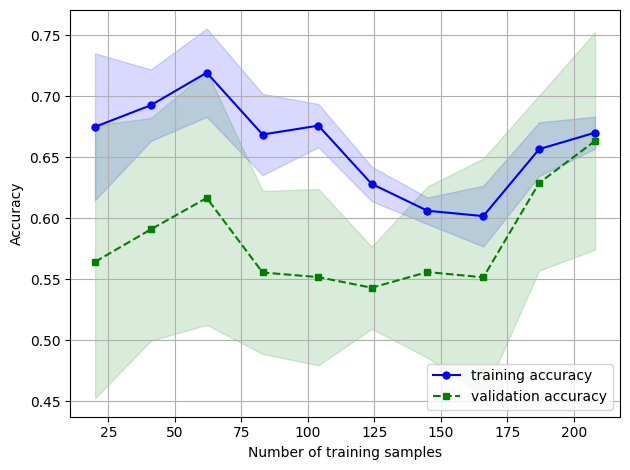

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 학습 곡선 얻기
train_sizes, train_scores, test_scores = learning_curve(estimator=final_model, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 그리기
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 의사결정나무

In [28]:
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Bayesian 최적화를 위한 목적 함수 정의
def dt_cv(criterion, splitter, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, min_impurity_decrease, max_leaf_nodes):
    params = {
        'criterion': 'gini' if criterion < 0.5 else 'entropy',
        'splitter': 'best' if splitter < 0.5 else 'random',
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'min_weight_fraction_leaf': min_weight_fraction_leaf,
        'min_impurity_decrease': min_impurity_decrease,
        'max_leaf_nodes': int(max_leaf_nodes) if max_leaf_nodes > 1 else None,
        'random_state': 42
    }

    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')  # 여러 클래스에 대해 가중치 평균 F1-score 사용

    return f1  # Bayesian 최적화는 목적 함수를 최대화하므로 F1-score를 그대로 반환

# Bayesian 최적화를 위한 파라미터 공간 정의
pbounds = {
    'criterion': (0, 1),
    'splitter': (0, 1),
    'max_depth': (3, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'min_weight_fraction_leaf': (0, 0.5),
    'min_impurity_decrease': (0, 0.5),
    'max_leaf_nodes': (2, 50)  # max_leaf_nodes는 2 이상이어야 함
}
# BayesianOptimization 객체 생성
dt_bo = BayesianOptimization(f=dt_cv, pbounds=pbounds, random_state=42)

# Gaussian Process 파라미터 설정
gp_params = {'alpha': 1e-5, 'n_restarts_optimizer': 2}

# GP 파라미터 설정 적용
dt_bo.set_gp_params(**gp_params)

# UtilityFunction 객체 생성
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# 최적화 수행, 목적 함수가 최대가 되는 최적해 찾기
dt_bo.maximize(init_points=5, n_iter=20, acquisition_function=utility)

# 최적의 하이퍼파라미터 얻기
best_params = dt_bo.max['params']

# 최적의 하이퍼파라미터를 사용하여 최종 모델 훈련
final_model = DecisionTreeClassifier(
    criterion='gini' if best_params['criterion'] < 0.5 else 'entropy',
    splitter='best' if best_params['splitter'] < 0.5 else 'random',
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    min_weight_fraction_leaf=best_params['min_weight_fraction_leaf'],
    min_impurity_decrease=best_params['min_impurity_decrease'],
    max_leaf_nodes=int(best_params['max_leaf_nodes']),
    random_state=42
)
final_model.fit(X_train, y_train)

# 최종 모델 테스트
final_y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, final_y_pred)

# classification_report에서 클래스 '1'의 값을 사용하도록 변경
classification_rep = classification_report(y_test, final_y_pred, output_dict=True)
precision = classification_rep['1']['precision']
recall = classification_rep['1']['recall']
f1 = classification_rep['1']['f1-score']

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# classification_report 출력
classification_rep_text = classification_report(y_test, final_y_pred)
print("Classification Report:\n", classification_rep_text)


|   iter    |  target   | criterion | max_depth | max_le... | min_im... | min_sa... | min_sa... | min_we... | splitter  |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.615     | 0.3745    | 19.16     | 37.14     | 0.2993    | 3.964     | 4.808     | 0.02904   | 0.8662    |
| 2         | 0.615     | 0.6011    | 15.04     | 2.988     | 0.485     | 16.82     | 5.822     | 0.09091   | 0.1834    |
| 3         | 0.615     | 0.3042    | 11.92     | 22.73     | 0.1456    | 12.63     | 4.511     | 0.1461    | 0.3664    |
| 4         | 0.615     | 0.4561    | 16.35     | 11.58     | 0.2571    | 12.26     | 2.836     | 0.3038    | 0.1705    |
| 5         | 0.615     | 0.06505   | 19.13     | 48.35     | 0.4042    | 6.788     | 3.758     | 0.3421    | 0.4402    |
| 6         | 0.615     | 0.1476    | 3.448     | 49.52     | 0.1394    | 18.55     | 19.93     | 0.2999    | 0.0332    |
| 7         | 0.615     

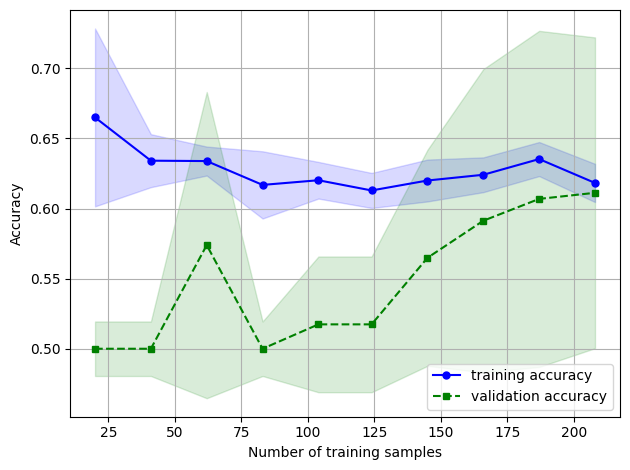

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 학습 곡선 얻기
train_sizes, train_scores, test_scores = learning_curve(estimator=final_model, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 그리기
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# SVM

In [30]:
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split

# F1-score를 스코어러로 설정
f1_scorer = make_scorer(f1_score, average='weighted')

# Bayesian 최적화를 위한 목적 함수 정의
def svm_cv(C, kernel, degree, gamma, coef0):
    params = {
        'C': max(C, 0),  # C가 음수가 되지 않도록 보장
        'kernel': 'linear' if kernel < 0.25 else 'poly' if kernel < 0.5 else 'rbf' if kernel < 0.75 else 'sigmoid',
        'degree': int(degree),  # degree를 정수로 변환
        'gamma': gamma if gamma > 0 else 'scale',
        'coef0': coef0,
        'class_weight': 'balanced',
        'random_state': 42
    }

    model = SVC(**params)

    # 교차검증을 통해 평균 F1-score 계산
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_scorer)
    return cv_scores.mean()

# Bayesian 최적화를 위한 파라미터 공간 정의
pbounds = {
    'C': (0.1, 10),
    'kernel': (0, 1),  # 0-0.25: linear, 0.25-0.5: poly, 0.5-0.75: rbf, 0.75-1: sigmoid
    'degree': (2, 5),  # degree는 보통 2-5 사이를 많이 사용
    'gamma': (0.0001, 1),
    'coef0': (0, 10)
}

# BayesianOptimization 객체 생성
svm_bo = BayesianOptimization(f=svm_cv, pbounds=pbounds, random_state=42)

# Gaussian Process 파라미터 설정
gp_params = {'alpha': 1e-5, 'n_restarts_optimizer': 2}
svm_bo.set_gp_params(**gp_params)

# UtilityFunction 객체 생성
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# 최적화 수행, 목적 함수가 최대가 되는 최적해 찾기
svm_bo.maximize(init_points=5, n_iter=20, acquisition_function=utility)

# 최적의 하이퍼파라미터 얻기
best_params = svm_bo.max['params']

# 범주형 변수 인덱스를 실제 값으로 변환
kernel = 'linear' if best_params['kernel'] < 0.25 else 'poly' if best_params['kernel'] < 0.5 else 'rbf' if best_params['kernel'] < 0.75 else 'sigmoid'

# 최적의 하이퍼파라미터를 사용하여 최종 모델 훈련
final_model = SVC(
    C=best_params['C'],
    kernel=kernel,
    degree=int(best_params['degree']),
    gamma=best_params['gamma'],
    coef0=best_params['coef0'],
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_train, y_train)

# 최종 모델 테스트
final_y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, final_y_pred)

# classification_report에서 클래스 '1'의 값을 사용하도록 변경
classification_rep = classification_report(y_test, final_y_pred, output_dict=True)
precision = classification_rep['1']['precision']
recall = classification_rep['1']['recall']
f1 = classification_rep['1']['f1-score']

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# classification_report 출력 (변경 없음)
classification_rep_text = classification_report(y_test, final_y_pred)
print("Classification Report:\n", classification_rep_text)


|   iter    |  target   |     C     |   coef0   |  degree   |   gamma   |  kernel   |
-------------------------------------------------------------------------------------
| 1         | 0.6506    | 3.808     | 9.507     | 4.196     | 0.5987    | 0.156     |
| 2         | 0.718     | 1.644     | 0.5808    | 4.599     | 0.6012    | 0.7081    |
| 3         | 0.6506    | 0.3038    | 9.699     | 4.497     | 0.2124    | 0.1818    |
| 4         | 0.6932    | 1.916     | 3.042     | 3.574     | 0.432     | 0.2912    |
| 5         | 0.6336    | 6.157     | 1.395     | 2.876     | 0.3664    | 0.4561    |
| 6         | 0.7096    | 0.5864    | 1.061     | 4.701     | 0.6087    | 0.646     |
| 7         | 0.6506    | 1.56      | 0.0       | 5.0       | 0.0001    | 0.0       |
| 8         | 0.5124    | 1.271     | 0.822     | 4.59      | 0.6683    | 0.761     |
| 9         | 0.6845    | 4.329     | 4.832     | 3.068     | 0.1789    | 0.3686    |
| 10        | 0.6336    | 6.4       | 2.179     | 2.57

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 학습 곡선 얻기
train_sizes, train_scores, test_scores = learning_curve(estimator=final_model, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 그리기
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# KNN

In [ ]:
import numpy as np
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score

# Bayesian 최적화를 위한 목적 함수 정의
def knn_cv(n_neighbors, weights, algorithm, metric):
    params = {
        'n_neighbors': int(n_neighbors),
        'weights': 'uniform' if weights < 0.5 else 'distance',
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'][int(algorithm)],
        'metric': ['euclidean', 'manhattan'][int(metric)]
    }

    model = KNeighborsClassifier(**params)

    # 교차검증
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score))
    return cv_scores.mean()  # F1-score의 평균을 반환

# Bayesian 최적화를 위한 파라미터 공간 정의
pbounds = {
    'n_neighbors': (10, 50),
    'weights': (0, 1),  # weights는 'uniform' 또는 'distance'로 변경될 것임
    'algorithm': (0, 3),  # algorithm은 'auto', 'ball_tree', 'kd_tree', 'brute' 중 선택
    'metric': (0, 1)  # metric은 'euclidean' 또는 'manhattan' 중 선택
}

# BayesianOptimization 객체 생성
knn_bo = BayesianOptimization(f=knn_cv, pbounds=pbounds, random_state=42)

# Gaussian Process 파라미터 설정
gp_params = {'alpha': 1e-5, 'n_restarts_optimizer': 2}

# GP 파라미터 설정 적용
knn_bo.set_gp_params(**gp_params)

# UtilityFunction 객체 생성
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# 최적화 수행, 목적 함수가 최대가 되는 최적해 찾기
knn_bo.maximize(init_points=5, n_iter=20, acquisition_function=utility)

# 최적의 하이퍼파라미터 얻기
best_params = knn_bo.max['params']
best_params['n_neighbors'] = int(best_params['n_neighbors'])
best_params['weights'] = 'uniform' if best_params['weights'] < 0.5 else 'distance'
best_params['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute'][int(best_params['algorithm'])]
best_params['metric'] = ['euclidean', 'manhattan'][int(best_params['metric'])]

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters found:")
print(best_params)

# 선택된 n_neighbors 값 출력
print(f"Selected n_neighbors: {best_params['n_neighbors']}")

# 최적의 하이퍼파라미터를 사용하여 최종 모델 훈련
final_model = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'],
    algorithm=best_params['algorithm'],
    metric=best_params['metric']
)

final_model.fit(X_train, y_train)

# 최종 모델 테스트
final_y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, final_y_pred)
precision = precision_score(y_test, final_y_pred)
recall = recall_score(y_test, final_y_pred)
f1 = f1_score(y_test, final_y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

classification_rep = classification_report(y_test, final_y_pred)
print("Classification Report:\n", classification_rep)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 학습 곡선 얻기
train_sizes, train_scores, test_scores = learning_curve(estimator=final_model, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 그리기
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 앙상블

## 보팅

### 하드 보팅

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 하이퍼 파라미터 튜닝 전 모델
# 하드보팅 모델 정의
log_clf = LogisticRegression(random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
svc_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
    voting='hard'
)

# 모델 학습
voting_clf.fit(X_train, y_train)

# 예측
y_pred = voting_clf.predict(X_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# 하드보팅 모델 정의
def hard_voting_cv(n_estimators, lr_eta, lr_max_depth, dt_max_depth, svc_C, svc_gamma):
    # 각 개별 분류기 정의
    log_clf = LogisticRegression(C=10 ** svc_C, max_iter=1000, random_state=42)
    dt_clf = DecisionTreeClassifier(max_depth=int(dt_max_depth), random_state=42)
    svc_clf = SVC(C=10 ** svc_C, gamma=10 ** svc_gamma, random_state=42)

    # VotingClassifier 정의
    voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
        voting='hard'
    )

    # 하드보팅 모델의 교차 검증 F1-score 계산
    f1 = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='f1').mean()

    return f1

# BayesianOptimization을 위한 하이퍼파라미터 공간 정의
pbounds = {
    'n_estimators': (1, 100),
    'lr_eta': (0.01, 0.3),
    'lr_max_depth': (1, 10),
    'dt_max_depth': (1, 10),
    'svc_C': (-6, 6),
    'svc_gamma': (-6, 6)
}

# BayesianOptimization 객체 생성
hard_voting_bo = BayesianOptimization(
    f=hard_voting_cv,
    pbounds=pbounds,
    random_state=42,
)

# 하드보팅 모델 하이퍼파라미터 최적화
hard_voting_bo.maximize(init_points=5, n_iter=20)

# 최적의 하이퍼파라미터 얻기
best_params = hard_voting_bo.max['params']

# 최적의 하이퍼파라미터를 사용하여 최종 모델 훈련
log_clf = LogisticRegression(C=10 ** best_params['svc_C'], max_iter=1000, random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=int(best_params['dt_max_depth']), random_state=42)
svc_clf = SVC(C=10 ** best_params['svc_C'], gamma=10 ** best_params['svc_gamma'], random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

# 최종 모델 평가
y_pred = voting_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 소프트보팅 모델 정의
soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
    voting='soft'
)

# 학습 곡선 얻기
train_sizes, train_scores, test_scores = learning_curve(estimator=voting_clf, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 그리기
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### 소프트 보팅

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# 하이퍼 파라미터 튜닝 전 모델
# 소프트보팅 모델 정의
log_clf = LogisticRegression(random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
svc_clf = SVC(probability=True, random_state=42)

# 소프트보팅 모델 정의
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
    voting='soft'
)

# 모델 학습
voting_clf.fit(X_train, y_train)

# 예측
y_pred = voting_clf.predict(X_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 소프트보팅 모델 정의
def soft_voting_cv(lr_C, dt_max_depth, svc_C, svc_gamma):
    # 각 개별 분류기 정의
    log_clf = LogisticRegression(C=10 ** lr_C, max_iter=1000, random_state=42)
    dt_clf = DecisionTreeClassifier(max_depth=int(dt_max_depth), random_state=42)
    svc_clf = SVC(C=10 ** svc_C, gamma=10 ** svc_gamma, probability=True, random_state=42)

    # VotingClassifier 정의
    voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
        voting='soft'
    )

    # 소프트보팅 모델의 교차 검증 F1 score 계산
    f1 = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='f1').mean()

    return f1

# BayesianOptimization을 위한 하이퍼파라미터 공간 정의
pbounds = {
    'lr_C': (-6, 6),
    'dt_max_depth': (1, 10),
    'svc_C': (-6, 6),
    'svc_gamma': (-6, 6)
}

# BayesianOptimization 객체 생성
soft_voting_bo = BayesianOptimization(
    f=soft_voting_cv,
    pbounds=pbounds,
    random_state=42,
)

# 소프트보팅 모델 하이퍼파라미터 최적화
soft_voting_bo.maximize(init_points=5, n_iter=20)

# 최적의 하이퍼파라미터 얻기
best_params = soft_voting_bo.max['params']

# 최적의 하이퍼파라미터를 사용하여 최종 모델 훈련
log_clf = LogisticRegression(C=10 ** best_params['lr_C'], max_iter=1000, random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=int(best_params['dt_max_depth']), random_state=42)
svc_clf = SVC(C=10 ** best_params['svc_C'], gamma=10 ** best_params['svc_gamma'], probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

# 최종 모델 평가
y_pred = voting_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 소프트보팅 모델 정의
soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
    voting='soft'
)

# 학습 곡선 얻기
train_sizes, train_scores, test_scores = learning_curve(estimator=voting_clf, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 그리기
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## 배깅

### Random Forest

In [ ]:
# Bayesian 최적화를 위한 목적 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, max_leaf_nodes):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'max_features': max_features,
        'max_leaf_nodes': int(max_leaf_nodes),
        'random_state': 42
    }

    model = RandomForestClassifier(**params)

    # 교차검증
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score))
    return cv_scores.mean()  # F1-score의 평균을 반환

# Bayesian 최적화를 위한 파라미터 공간 정의
pbounds = {
    'n_estimators': (50, 200),  # n_estimators에 대한 탐색 범위 추가
    'max_depth': (10, 20),
    'min_samples_split': (10, 40),
    'min_samples_leaf': (5, 10),
    'max_features': (0.1, 1.0),
    'max_leaf_nodes': (50, 150)
}

# BayesianOptimization 객체 생성
rf_bo = BayesianOptimization(f=rf_cv, pbounds=pbounds, random_state=42)

# Gaussian Process 파라미터 설정
gp_params = {'alpha': 1e-5, 'n_restarts_optimizer': 2}

# GP 파라미터 설정 적용
rf_bo.set_gp_params(**gp_params)

# UtilityFunction 객체 생성
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# 최적화 수행, 목적 함수가 최대가 되는 최적해 찾기
rf_bo.maximize(init_points=5, n_iter=20, acquisition_function=utility)

# 최적의 하이퍼파라미터 얻기
best_params = rf_bo.max['params']

# Hyperparameters need to be rounded to integers
best_params = {param_name: int(round(best_params[param_name])) for param_name in best_params}

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters found:")
print(best_params)

# 최적의 하이퍼파라미터를 사용하여 최종 모델 훈련
final_model = RandomForestClassifier(criterion='gini', **best_params)  # n_estimators는 최적의 값으로 설정하지 않음
final_model.fit(X_train, y_train)

# 최종 모델 테스트
final_y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, final_y_pred)
precision = precision_score(y_test, final_y_pred)
recall = recall_score(y_test, final_y_pred)
f1 = f1_score(y_test, final_y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 학습 곡선 얻기
train_sizes, train_scores, test_scores = learning_curve(estimator=voting_clf, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 그리기
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## 부스팅

### XGBoost

In [ ]:
# xgb.DMatrix로 변환
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
from bayes_opt import BayesianOptimization, UtilityFunction
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Bayesian 최적화를 위한 목적 함수 정의
def xgb_cv(n_estimators,eta, max_depth, subsample, colsample_bytree, min_child_weight, reg_lambda):
    params = {
        'objective': 'binary:logistic',
        'n_estimators': int(n_estimators),
        'eta': max(eta, 0),  # eta가 음수가 되지 않도록 보장
        'max_depth': int(max_depth),  # max_depth를 정수로 변환
        'subsample': max(min(subsample, 1), 0),  # subsample을 [0, 1] 범위로 제한
        'colsample_bytree': max(min(colsample_bytree, 1), 0),  # colsample_bytree를 [0, 1] 범위로 제한
        'min_child_weight': int(min_child_weight),  # min_child_weight를 정수로 변환
        'reg_lambda': max(reg_lambda, 0)  # lambda를 양수로 보장
    }

    model = xgb.XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return f1  # Bayesian 최적화는 목적 함수를 최대화하므로 F1-score를 그대로 반환

# Bayesian 최적화를 위한 파라미터 공간 정의
pbounds = {
    'eta': (0.01, 0.3),
    'n_estimators': (1, 1000),
    'min_child_weight': (1, 10),
    'max_depth': (3, 8),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'reg_lambda': (1, 10)
}

# BayesianOptimization 객체 생성
xgb_bo = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)

# Gaussian Process 파라미터 설정
gp_params = {'alpha': 1e-5, 'n_restarts_optimizer': 2}

# GP 파라미터 설정 적용
xgb_bo.set_gp_params(**gp_params)

# UtilityFunction 객체 생성
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# 최적화 수행, 목적 함수가 최대가 되는 최적해 찾기
xgb_bo.maximize(init_points=5, n_iter=20, acquisition_function=utility)

# 최적의 하이퍼파라미터 얻기
best_params = xgb_bo.max['params']

# 최적의 하이퍼파라미터를 사용하여 최종 모델 훈련
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_estimators=int(best_params['n_estimators']),
    colsample_bytree=best_params['colsample_bytree'],
    eta=best_params['eta'],
    max_depth=int(best_params['max_depth']),
    min_child_weight=int(best_params['min_child_weight']),
    subsample=best_params['subsample'],
    reg_lambda=best_params['reg_lambda']
)

final_model.fit(X_train, y_train)

# 최종 모델 테스트
final_y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, final_y_pred)
precision = precision_score(y_test, final_y_pred)
recall = recall_score(y_test, final_y_pred)
f1 = f1_score(y_test, final_y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


In [ ]:
# 학습 곡선 얻기
train_sizes, train_scores, test_scores = learning_curve(estimator=final_model, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 그리기
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### CatBoost

In [ ]:
from bayes_opt import BayesianOptimization, UtilityFunction
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


# Bayesian 최적화를 위한 목적 함수 정의
def catboost_cv(iterations, learning_rate, depth, l2_leaf_reg, random_strength, bagging_temperature, class_weights):
    params = {
        'iterations': int(iterations),
        'learning_rate': max(min(learning_rate, 1), 0),  # learning_rate를 [0, 1] 범위로 제한
        'depth': int(depth),
        'l2_leaf_reg': int(l2_leaf_reg),
        'random_strength': max(random_strength, 0),
        'bagging_temperature': max(bagging_temperature, 0),
        'grow_policy': 'SymmetricTree',  # 고정
        'class_weights': [1.0, max(class_weights, 0)],  # class_weights를 양수로 보장
        'random_seed': 42,
        'eval_metric': 'F1',
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=5, verbose=False)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return f1  # Bayesian 최적화는 목적 함수를 최대화하므로 F1-score를 그대로 반환

# Bayesian 최적화를 위한 파라미터 공간 정의
pbounds = {
    'iterations': (100, 1000),
    'learning_rate': (0.01, 0.3),
    'depth': (1, 16),
    'l2_leaf_reg': (1, 10),
    'random_strength': (0.1, 10),
    'bagging_temperature': (0.0, 1.0),
    'class_weights': (1.0, 10.0)
}

# BayesianOptimization 객체 생성
catboost_bo = BayesianOptimization(f=catboost_cv, pbounds=pbounds, random_state=42)

# Gaussian Process 파라미터 설정
gp_params = {'alpha': 1e-5, 'n_restarts_optimizer': 2}

# GP 파라미터 설정 적용
catboost_bo.set_gp_params(**gp_params)

# UtilityFunction 객체 생성
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# 최적화 수행, 목적 함수가 최대가 되는 최적해 찾기
catboost_bo.maximize(init_points=5, n_iter=20, acquisition_function=utility)

# 최적의 하이퍼파라미터 얻기
best_params = catboost_bo.max['params']

# 최적의 하이퍼파라미터를 사용하여 최종 모델 훈련
final_model = CatBoostClassifier(
    iterations=int(best_params['iterations']),
    learning_rate=best_params['learning_rate'],
    depth=int(best_params['depth']),
    l2_leaf_reg=int(best_params['l2_leaf_reg']),
    random_strength=best_params['random_strength'],
    bagging_temperature=best_params['bagging_temperature'],
    grow_policy='SymmetricTree',
    class_weights=[1.0, best_params['class_weights']],
    random_seed=42,
    eval_metric='F1',
    verbose=0
)

final_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=5, verbose=False)

# 최종 모델 테스트
final_y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, final_y_pred)
precision = precision_score(y_test, final_y_pred)
recall = recall_score(y_test, final_y_pred)
f1 = f1_score(y_test, final_y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


In [ ]:
# 학습 곡선 얻기
train_sizes, train_scores, test_scores = learning_curve(estimator=final_model, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 그리기
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 스태킹

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 기본 모델 정의
log_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()
svc_clf = SVC()

# Stacking 모델 정의
stacking_clf = StackingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', make_pipeline(StandardScaler(), svc_clf))],
    final_estimator=LogisticRegression(),
    stack_method='auto',
    cv=5
)

# Stacking 모델 교차 검증
cv_scores = cross_val_score(stacking_clf, X_train, y_train, cv=5)

# 모델 학습
stacking_clf.fit(X_train, y_train)

# 예측
y_pred = stacking_clf.predict(X_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Cross-Validation Mean Accuracy:", np.mean(cv_scores))
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)


In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Stacking 모델 정의
def stacking_cv(lr_C, dt_max_depth, svc_C, svc_gamma):
    # 각 개별 분류기 정의
    log_clf = LogisticRegression(C=10 ** lr_C, max_iter=1000, random_state=42)
    dt_clf = DecisionTreeClassifier(max_depth=int(dt_max_depth), random_state=42)
    svc_clf = SVC(C=10 ** svc_C, gamma=10 ** svc_gamma, probability=True, random_state=42)

    # StackingClassifier 정의
    stacking_clf = StackingClassifier(
        estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
        final_estimator=LogisticRegression(),
        cv=5,
        n_jobs=-1
    )

    # Stacking 모델의 교차 검증 F1 score 계산
    f1 = cross_val_score(stacking_clf, X_train, y_train, cv=5, scoring='f1').mean()

    return f1

# BayesianOptimization을 위한 하이퍼파라미터 공간 정의
pbounds = {
    'lr_C': (-6, 6),
    'dt_max_depth': (1, 10),
    'svc_C': (-6, 6),
    'svc_gamma': (-6, 6)
}

# BayesianOptimization 객체 생성
stacking_bo = BayesianOptimization(
    f=stacking_cv,
    pbounds=pbounds,
    random_state=42,
)

# Stacking 모델 하이퍼파라미터 최적화
stacking_bo.maximize(init_points=5, n_iter=20)

# 최적의 하이퍼파라미터 얻기
best_params = stacking_bo.max['params']

# 최적의 하이퍼파라미터를 사용하여 최종 모델 훈련
log_clf = LogisticRegression(C=10 ** best_params['lr_C'], max_iter=1000, random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=int(best_params['dt_max_depth']), random_state=42)
svc_clf = SVC(C=10 ** best_params['svc_C'], gamma=10 ** best_params['svc_gamma'], probability=True, random_state=42)

stacking_clf = StackingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)

# 최종 모델 평가
y_pred = stacking_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 소프트보팅 모델 정의
soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svc_clf)],
    voting='soft'
)

# 학습 곡선 얻기
train_sizes, train_scores, test_scores = learning_curve(estimator=stacking_clf, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 그리기
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# 딥러닝

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

Epoch 1/500
2/2 [==============================] - 1s 336ms/step - loss: 0.9427 - accuracy: 0.4569 - val_loss: 0.8466 - val_accuracy: 0.3125
Epoch 2/500
2/2 [==============================] - 0s 65ms/step - loss: 0.7976 - accuracy: 0.5000 - val_loss: 0.8133 - val_accuracy: 0.3125
Epoch 3/500
2/2 [==============================] - 0s 67ms/step - loss: 0.7644 - accuracy: 0.5259 - val_loss: 0.7803 - val_accuracy: 0.3333
Epoch 4/500
2/2 [==============================] - 0s 69ms/step - loss: 0.8322 - accuracy: 0.5043 - val_loss: 0.7499 - val_accuracy: 0.3542
Epoch 5/500
2/2 [==============================] - 0s 55ms/step - loss: 0.8169 - accuracy: 0.4957 - val_loss: 0.7216 - val_accuracy: 0.3958
Epoch 6/500
2/2 [==============================] - 0s 73ms/step - loss: 0.8197 - accuracy: 0.4957 - val_loss: 0.6967 - val_accuracy: 0.4167
Epoch 7/500
2/2 [==============================] - 0s 81ms/step - loss: 0.6984 - accuracy: 0.5560 - val_loss: 0.6742 - val_accuracy: 0.4583
Epoch 8/500
2/2 [==

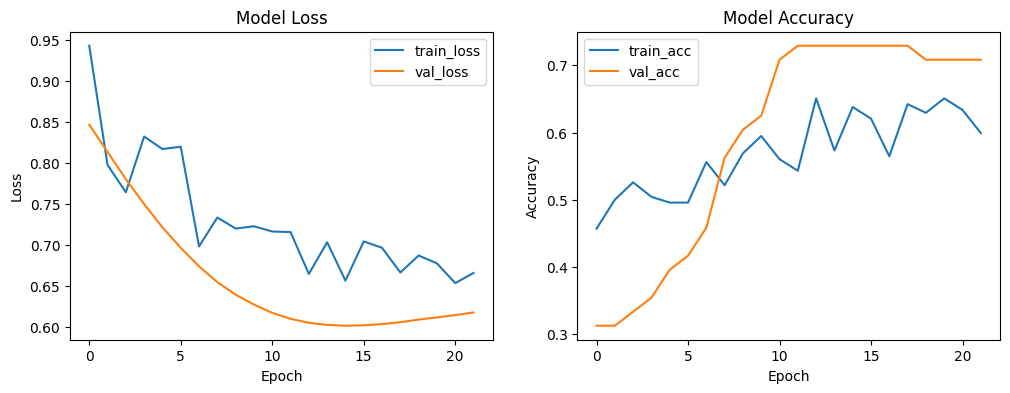

2/2 [==============================] - 0s 9ms/step
Loaded Model Accuracy: 0.7291666666666666
Loaded Model Precision: 0.5
Loaded Model Recall: 0.8461538461538461
Loaded Model F1-score: 0.6285714285714286
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.69      0.79        35
           1       0.50      0.85      0.63        13

    accuracy                           0.73        48
   macro avg       0.71      0.77      0.71        48
weighted avg       0.81      0.73      0.74        48



In [37]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import random


# 난수 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 모델 학습 및 평가 함수
def build_and_train_model(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(3,)))

    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.005)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    # 조기 종료 콜백 설정
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    # 모델 학습 (validation_split 사용)
    history = model.fit(
        X_train, y_train,
        epochs=500,
        batch_size=128,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )

    return model, history

# 성능 지표 계산 함수
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1

# 데이터 로드 (예시)
# X_train, y_train, X_test, y_test = load_data()  # 사용자 데이터 로드

model, history = build_and_train_model(X_train, y_train, X_test, y_test)
accuracy, precision, recall, f1 = evaluate_model(model, X_test, y_test)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

model.save('best_deep_learning_model_final.keras')
print("Model saved with recall:", recall)

# 손실 및 정확도 그래프 그리기 함수
def plot_loss_acc(history):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 손실 및 정확도 그래프 그리기
plot_loss_acc(history)

# 로드한 모델로 다시 예측 (옵션)
loaded_model = keras.models.load_model('best_deep_learning_model_final.keras')
loaded_accuracy, loaded_precision, loaded_recall, loaded_f1 = evaluate_model(loaded_model, X_test, y_test)
final_y_pred = model.predict(X_test)
final_y_pred = (final_y_pred > 0.5).astype(int)

print(f"Loaded Model Accuracy: {loaded_accuracy}")
print(f"Loaded Model Precision: {loaded_precision}")
print(f"Loaded Model Recall: {loaded_recall}")
print(f"Loaded Model F1-score: {loaded_f1}")
classification_rep = classification_report(y_test, final_y_pred)
print("Classification Report:\n", classification_rep)


In [33]:
# 모든 컬럼을 보여주도록 설정
pd.set_option('display.max_columns', None)

new_df = pd.read_excel('/content/drive/MyDrive/2024_4_predict.xlsx')

new_df

,지역,hum,tem,rain,SO2,NO2,O3,CO,PM10,PM2.5,wind,sun
0,경기,71.834876,6.466667,69.132888,0.002329,0.018134,0.020476,0.387251,33.303054,19.772355,0.996515,53.721030
1,서울,63.385018,7.900000,79.205387,0.002590,0.021754,0.022519,0.475667,31.248745,17.197317,2.337136,52.111219
2,강원,71.103295,6.095175,59.869845,0.002139,0.009588,0.025769,0.390000,18.003863,13.746667,1.417870,54.295458
3,충북,76.287120,6.833333,33.595230,0.001890,0.013517,0.022375,0.472457,34.861662,20.041398,1.313932,53.597222
4,충남,73.350400,7.538017,21.000000,0.002725,0.012547,0.028703,0.355686,37.775004,21.403471,1.244218,49.492778
5,경남,69.184060,9.866667,52.333333,0.002695,0.016453,0.028333,0.436667,21.108717,13.849865,1.426650,60.004048
6,경북,69.692956,8.133333,49.153058,0.002375,0.011550,0.028410,0.450733,30.680171,18.249146,1.757953,58.964196
7,전북,75.980075,8.700000,74.266667,0.001807,0.010047,0.029032,0.348714,33.902353,18.146865,1.554277,49.142333
8,전남,74.658753,10.600000,53.300000,0.002267,0.009128,0.030762,0.370129,25.950220,13.695685,2.433481,52.093333
9,제주,73.143192,14.100000,24.659044,0.001467,0.007143,0.041120,0.275653,25.444405,10.919914,4.139363,47.784658


In [34]:
new_X_df = new_df[['hum', 'tem', 'rain', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5','wind', 'sun']]
new_X_df

,hum,tem,rain,SO2,NO2,O3,CO,PM10,PM2.5,wind,sun
0,71.834876,6.466667,69.132888,0.002329,0.018134,0.020476,0.387251,33.303054,19.772355,0.996515,53.721030
1,63.385018,7.900000,79.205387,0.002590,0.021754,0.022519,0.475667,31.248745,17.197317,2.337136,52.111219
2,71.103295,6.095175,59.869845,0.002139,0.009588,0.025769,0.390000,18.003863,13.746667,1.417870,54.295458
3,76.287120,6.833333,33.595230,0.001890,0.013517,0.022375,0.472457,34.861662,20.041398,1.313932,53.597222
4,73.350400,7.538017,21.000000,0.002725,0.012547,0.028703,0.355686,37.775004,21.403471,1.244218,49.492778
5,69.184060,9.866667,52.333333,0.002695,0.016453,0.028333,0.436667,21.108717,13.849865,1.426650,60.004048
6,69.692956,8.133333,49.153058,0.002375,0.011550,0.028410,0.450733,30.680171,18.249146,1.757953,58.964196
7,75.980075,8.700000,74.266667,0.001807,0.010047,0.029032,0.348714,33.902353,18.146865,1.554277,49.142333
8,74.658753,10.600000,53.300000,0.002267,0.009128,0.030762,0.370129,25.950220,13.695685,2.433481,52.093333
9,73.143192,14.100000,24.659044,0.001467,0.007143,0.041120,0.275653,25.444405,10.919914,4.139363,47.784658


In [35]:
# 스케일링
scaler = StandardScaler()
new_X_df_scaled =new_X_df.copy()
new_X_df_scaled[new_X_df.columns] = scaler.fit_transform(new_X_df[new_X_df.columns])
# 결과 확인
new_X_df_scaled

,hum,tem,rain,SO2,NO2,O3,CO,PM10,PM2.5,wind,sun
0,-0.007444,-0.949037,0.915346,0.259207,1.189930,-1.318721,-0.150818,0.673247,0.939659,-0.988906,0.158755
1,-2.328531,-0.318297,1.442755,0.931063,2.026806,-0.948349,1.323452,0.333866,0.151519,0.542645,-0.266901
2,-0.208401,-1.112512,0.430321,-0.228715,-0.785521,-0.359163,-0.104975,-1.854248,-0.904619,-0.507542,0.310641
3,1.215541,-0.787685,-0.945452,-0.871478,0.122798,-0.974431,1.269929,0.930736,1.022005,-0.626283,0.126018
4,0.408855,-0.477588,-1.604955,1.278324,-0.101530,0.172748,-0.677136,1.412033,1.438893,-0.705925,-0.959253
5,-0.735595,0.547136,0.035699,1.201894,0.801344,0.105767,0.673153,-1.341312,-0.873033,-0.497511,1.820071
6,-0.595807,-0.215619,-0.130824,0.377145,-0.331946,0.119663,0.907704,0.239935,0.473452,-0.119025,1.545120
7,1.131199,0.033743,1.184157,-1.084570,-0.679311,0.232505,-0.793387,0.772254,0.442147,-0.351708,-1.051916
8,0.768246,0.869840,0.086315,0.098569,-0.891800,0.546030,-0.436311,-0.541474,-0.920223,0.652711,-0.271631
9,0.351937,2.410018,-1.413363,-1.961439,-1.350770,2.423951,-2.011612,-0.625037,-1.769801,2.601543,-1.410904


In [38]:
loaded_model = keras.models.load_model('best_deep_learning_model_final.keras')

In [39]:
final_y_pred = loaded_model.predict(new_X_df_scaled)
final_y_pred

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 3), found shape=(None, 11)


In [40]:
# 데이터프레임으로 변환
df_final = pd.DataFrame(final_y_pred, columns=['Prediction'])

In [41]:
df_final

,Prediction
0,0
1,1
2,1
3,1
4,0
5,0
6,0
7,1
8,1
9,0


In [ ]:

# Excel 파일로 저장
df_final.to_excel('2024_4_disease_predict.xlsx', index=False, engine='openpyxl')

In [43]:
df_1  = pd.read_excel("/content/drive/MyDrive/2024_1_predict.xlsx")
df_1.drop('지역',axis=1, inplace=True)
df_1

,hum,tem,rain,SO2,NO2,O3,CO,PM10,PM2.5,wind,sun
0,63.337189,2.100000,66.409261,0.002525,0.022848,0.026929,0.442665,42.898763,29.584130,1.482935,59.347061
1,55.796916,3.533333,72.874324,0.002737,0.025066,0.026148,0.519463,40.978943,26.459490,2.461593,57.113003
2,61.557502,1.390350,15.939796,0.002539,0.014742,0.032118,0.464208,33.071628,22.080000,1.595135,60.545716
3,64.562668,2.500000,37.681187,0.002122,0.016317,0.028588,0.517125,43.679597,27.089396,1.533667,62.410667
4,68.485744,2.290509,29.400000,0.003233,0.013729,0.035253,0.386098,42.367181,27.910897,1.437748,63.636111
5,60.593660,5.533333,45.866667,0.003111,0.020151,0.030900,0.486667,27.996773,18.432201,1.689566,60.915238
6,58.700881,4.033333,41.656859,0.002741,0.013823,0.032808,0.491421,39.489193,22.445378,2.065999,61.816994
7,66.824572,3.500000,22.500000,0.002125,0.013153,0.032942,0.409235,40.730517,24.208266,1.742940,59.275333
8,66.887548,5.300000,42.633333,0.002492,0.011545,0.033782,0.409995,34.197105,16.450005,2.936899,58.385641
9,66.642671,9.033333,22.916692,0.001467,0.008197,0.044207,0.320424,31.959783,15.540405,4.256648,47.698930


In [44]:
y_pred = loaded_model.predict(df_1)
y_pred

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 3), found shape=(None, 11)


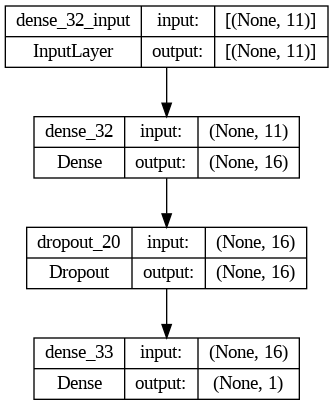

In [ ]:
plot_model(loaded_model, show_shapes=True)

In [ ]:
loaded_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 16)                192       
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 17        
                                                                 
Total params: 209 (836.00 Byte)
Trainable params: 209 (836.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
